In [5]:
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm import trange
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

In [52]:
class CNN1D(nn.Module):
    def __init__(self, number_of_categories):
        super(CNN1D, self).__init__()
        # convolution layer
        # in_channels must be the same as the number of subcarriers, out_channels can be any value
        self.conv1d = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        self.conv1d_2 = nn.Conv1d(in_channels=64, out_channels=40, kernel_size=5, stride=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.relu = nn.ReLU()

        # calculate the in_features
        self.fc1 = nn.Linear(in_features=40 * 17, out_features=128)
        # self.fc1 = nn.Linear(in_features=40 * 19, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=number_of_categories)

    def forward(self, x):
        # input tensor size [batch_size, 64 (features), 40 (sequence length)]
        x = self.conv1d(x)
        # [batch_size, 64 (features), 40 (sequence length)]
        x = self.relu(x)
        x = self.conv1d_2(x)
        # [batch_size, 64 (features), 40 (sequence length)]
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, x.shape[1] * x.shape[2])  # Adjust the input size based on the output size after convolutions and pooling
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [7]:
class CSIDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.int)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [8]:
def importData():
    X_train, X_val, X_test, y_train, y_val, y_test = [], [], [], [], [], []
    for i in range(10):
        temp_train = np.load(f'../data/processed_data/{i}_table_train.npy')
        temp_val = np.load(f'../data/processed_data/{i}_table_val.npy')
        temp_test = np.load(f'../data/processed_data/{i}_table_test.npy')
        if i == 0:
            X_train = temp_train
            X_val = temp_val
            X_test = temp_test
            y_train = np.array([[i] for _ in range(X_train.shape[0])])
            y_val = np.array([[i] for _ in range(X_val.shape[0])])
            y_test = np.array([[i] for _ in range(X_test.shape[0])])
        else:
            X_train = np.append(X_train, temp_train, axis=0)
            X_val = np.append(X_val, temp_val, axis=0)
            X_test = np.append(X_test, temp_test, axis=0)
            y_train = np.append(y_train, np.array([[i] for _ in range(temp_train.shape[0])]), axis=0)
            y_val = np.append(y_val, np.array([[i] for _ in range(temp_val.shape[0])]), axis=0)
            y_test = np.append(y_test, np.array([[i] for _ in range(temp_test.shape[0])]), axis=0)
            
    return X_train, X_val, X_test, y_train, y_val, y_test

In [9]:
class RunningAverage:
    def __init__(self):
        self.steps = 0
        self.total = 0

    def update(self, val):
        self.total += val
        self.steps += 1

    def __call__(self):
        return self.total / float(self.steps)

def accuracy(outputs, labels):
    # outputs (predicted), labels (true)
    outputs = np.argmax(outputs.cpu().detach().numpy(), axis=1)
    labels = labels.squeeze()
    # compare outputs with labels
    return np.sum([1 if first == second else 0 for first, second in zip(labels, outputs)]) / float(len(labels))

In [10]:
def train(model, optimizer, trainLoader, loss_fn, iterations):
    model.train()
    train_loss = RunningAverage()
    train_acc = RunningAverage()
    
    with trange(iterations) as pbar:
        for X_batch, y_batch in trainLoader:
            y_batch = y_batch.type(torch.LongTensor).squeeze(1)
            logits = model(X_batch)
            y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
            loss = loss_fn(logits, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss.update(loss)
            train_acc.update(accuracy(y_pred, y_batch))
            pbar.update(1)
            
    return train_loss(), train_acc()
    
def eval(model, valLoader, loss_fn):
    model.eval()
    eval_loss = RunningAverage()
    eval_acc = RunningAverage()
    
    with torch.no_grad():
        for X_batch, y_batch in valLoader:
            y_batch = y_batch.type(torch.LongTensor).squeeze(1)
            logits = model(X_batch)
            y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
            loss = loss_fn(logits, y_batch)
            
            eval_loss.update(loss)
            eval_acc.update(accuracy(y_pred, y_batch))
            
    return eval_loss(), eval_acc()
    
def test(model, testLoader, test_size):
    model.eval()
    for X_batch, y_batch in testLoader:
        y_batch = y_batch.type(torch.LongTensor).squeeze(1)
        logits = model(X_batch)
        y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
        
    print(f"Overall Accuracy: {accuracy(y_pred, y_batch):.3f}")

    # True positive percentage
    percentages = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
    # outputs (predicted), labels (true)
    outputs = np.argmax(y_pred.cpu().detach().numpy(), axis=1)
    labels = y_batch.squeeze()
    
    for i in range(len(outputs)):
        if outputs[i] == labels[i]:
            percentages[outputs[i]] += 1
    
    # plot the percentages of correct predictions
    y_percent = [(value/(test_size/10))*100 for key, value in percentages.items()]
    x_label = [str(key) for key, _ in percentages.items()]
    
    fig, test = plt.subplots(figsize=(10,6))
    test.bar(x_label, y_percent)
    test.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Key")
    plt.title("Accuracy (%) per key")
    plt.savefig("percentage_correct.png")
    plt.show()
    
    cm = confusion_matrix(y_true=labels, y_pred=outputs)
    cm = np.divide(cm, (test_size/10))
    
    plt.figure(figsize=(10,6))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.savefig("confusion_matrix.png")
    plt.show()
    
    print(f"Accuracy for each key: {''.join([x + ': ' + str(round(y, 3)) + '% ' for x, y in zip(x_label, y_percent)])}")
    
    print(classification_report(y_true=labels, y_pred=outputs, target_names=x_label))

In [11]:
def train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss_fn, iterations):
    # for plotting the loss and accuracy
    train_loss_list, train_acc_list, eval_loss_list, eval_acc_list  = [], [], [], []
        
    for epoch in range(epochs):
        train_loss, train_acc = train(model, optimizer, trainLoader, loss_fn, iterations)
        eval_loss, eval_acc = eval(model, valLoader, loss_fn)
        
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        eval_loss_list.append(eval_loss)
        eval_acc_list.append(eval_acc)
        
        print(f"Train: Epoch {epoch}: Loss {train_loss}, Accuracy {train_acc}")
        print(f"Eval: Epoch {epoch}: Loss {eval_loss}, Accuracy {eval_acc}")
        
    return train_loss_list, train_acc_list, eval_loss_list, eval_acc_list
        

In [31]:
def plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs):
    x = [i for i in range(1, epochs+1)]
    
    fig, loss = plt.subplots(figsize=(10,6))
    loss.plot(x, [trainLoss.item() for trainLoss in train_loss_list], label="Training Loss")
    loss.plot(x, [evalLoss.item() for evalLoss in eval_loss_list], label="Validation Loss")
    plt.legend()
    plt.ylabel("Average Loss")
    plt.xlabel("Epochs")
    plt.title("Average Loss per epoch")
    plt.savefig("loss_per_epoch.png")
    
    plt.show()
    
    fig, acc = plt.subplots(figsize=(10,6))
    acc.plot(x, [trainAcc.item() for trainAcc in train_acc_list], label="Training Accuracy")
    acc.plot(x, [evalAcc.item() for evalAcc in eval_acc_list], label="Validation Accuracy")
    plt.legend()
    plt.ylabel("Average Accuracy")
    plt.xlabel("Epochs")
    plt.title("Average Accuracy per epoch")
    plt.savefig("acc_per_epoch.png")
    plt.show()

In [13]:
def print_model_parameters(model):
    total_parameters = 0
    print(" "*20 + "Model Parameters" + " "*20)
    print("="*57)
    print(f"{'Layer':<25}" + "| Parameters")
    print("="*57)
    for name, param in model.named_parameters():
        temp = 1
        temp_list = []
        if param.requires_grad:
            print(f"{name:<25}", end="")
            for i in param.data.shape:
                temp *= i
                temp_list.append(str(i))
            print(": ", end="")
            if len(temp_list) > 1:
                print(f"{' * '.join(temp_list)}", end="")
                print(" = " + str(temp))
            else:
                print(f"{''.join(temp_list)}")

        total_parameters += temp
        
    print("="*57)
    print(f"{'Total parameters':<25}" + f": {total_parameters}")
    print("="*57)

100%|██████████| 33/33 [00:00<00:00, 79.32it/s]


Train: Epoch 0: Loss 2.272913694381714, Accuracy 0.16054778554778557
Eval: Epoch 0: Loss 2.165900707244873, Accuracy 0.19427083333333334


100%|██████████| 33/33 [00:00<00:00, 87.76it/s]


Train: Epoch 1: Loss 1.9928128719329834, Accuracy 0.33340617715617715
Eval: Epoch 1: Loss 1.828857183456421, Accuracy 0.3927083333333333


100%|██████████| 33/33 [00:00<00:00, 85.93it/s]


Train: Epoch 2: Loss 1.6195398569107056, Accuracy 0.48696095571095577
Eval: Epoch 2: Loss 1.4409234523773193, Accuracy 0.5375


100%|██████████| 33/33 [00:00<00:00, 87.30it/s]


Train: Epoch 3: Loss 1.2833802700042725, Accuracy 0.5821314102564104
Eval: Epoch 3: Loss 1.1824066638946533, Accuracy 0.6260416666666667


100%|██████████| 33/33 [00:00<00:00, 89.00it/s]


Train: Epoch 4: Loss 1.0699663162231445, Accuracy 0.6358901515151515
Eval: Epoch 4: Loss 1.0294673442840576, Accuracy 0.6515625


100%|██████████| 33/33 [00:00<00:00, 86.55it/s]


Train: Epoch 5: Loss 0.9485824704170227, Accuracy 0.6671401515151515
Eval: Epoch 5: Loss 0.9188974499702454, Accuracy 0.6572916666666667


100%|██████████| 33/33 [00:00<00:00, 77.10it/s]


Train: Epoch 6: Loss 0.8664793968200684, Accuracy 0.6959863053613053
Eval: Epoch 6: Loss 0.8528072237968445, Accuracy 0.6635416666666667


100%|██████████| 33/33 [00:00<00:00, 72.85it/s]


Train: Epoch 7: Loss 0.8148489594459534, Accuracy 0.7064758158508159
Eval: Epoch 7: Loss 0.8505590558052063, Accuracy 0.6786458333333333


100%|██████████| 33/33 [00:00<00:00, 88.23it/s]


Train: Epoch 8: Loss 0.7461807131767273, Accuracy 0.7297494172494172
Eval: Epoch 8: Loss 0.8027991056442261, Accuracy 0.7145833333333333


100%|██████████| 33/33 [00:00<00:00, 80.29it/s]


Train: Epoch 9: Loss 0.7004541754722595, Accuracy 0.7466856060606061
Eval: Epoch 9: Loss 0.749450147151947, Accuracy 0.725


100%|██████████| 33/33 [00:00<00:00, 87.30it/s]


Train: Epoch 10: Loss 0.6692408919334412, Accuracy 0.7599067599067599
Eval: Epoch 10: Loss 0.7154684066772461, Accuracy 0.6942708333333333


100%|██████████| 33/33 [00:00<00:00, 95.38it/s]


Train: Epoch 11: Loss 0.6581225395202637, Accuracy 0.7624198717948718
Eval: Epoch 11: Loss 0.6825622320175171, Accuracy 0.7416666666666667


100%|██████████| 33/33 [00:00<00:00, 88.47it/s]


Train: Epoch 12: Loss 0.6275125741958618, Accuracy 0.7687572843822843
Eval: Epoch 12: Loss 0.6376809477806091, Accuracy 0.7755208333333333


100%|██████████| 33/33 [00:00<00:00, 90.66it/s]


Train: Epoch 13: Loss 0.5769994854927063, Accuracy 0.8085664335664335
Eval: Epoch 13: Loss 0.6337683796882629, Accuracy 0.7333333333333333


100%|██████████| 33/33 [00:00<00:00, 83.43it/s]


Train: Epoch 14: Loss 0.5496525168418884, Accuracy 0.8116258741258742
Eval: Epoch 14: Loss 0.5984025597572327, Accuracy 0.8098958333333334


100%|██████████| 33/33 [00:00<00:00, 82.50it/s]


Train: Epoch 15: Loss 0.5449577569961548, Accuracy 0.7970935314685316
Eval: Epoch 15: Loss 0.6018341779708862, Accuracy 0.771875


100%|██████████| 33/33 [00:00<00:00, 85.15it/s]


Train: Epoch 16: Loss 0.529245913028717, Accuracy 0.8131191724941725
Eval: Epoch 16: Loss 0.647128701210022, Accuracy 0.7515625


100%|██████████| 33/33 [00:00<00:00, 90.98it/s]


Train: Epoch 17: Loss 0.5140454769134521, Accuracy 0.819456585081585
Eval: Epoch 17: Loss 0.5690345168113708, Accuracy 0.771875


100%|██████████| 33/33 [00:00<00:00, 90.41it/s]


Train: Epoch 18: Loss 0.4827711582183838, Accuracy 0.8385052447552448
Eval: Epoch 18: Loss 0.5495050549507141, Accuracy 0.7953125


100%|██████████| 33/33 [00:00<00:00, 86.61it/s]


Train: Epoch 19: Loss 0.48982471227645874, Accuracy 0.8106060606060606
Eval: Epoch 19: Loss 0.6142808198928833, Accuracy 0.7520833333333333


100%|██████████| 33/33 [00:00<00:00, 91.16it/s]


Train: Epoch 20: Loss 0.4902372658252716, Accuracy 0.8137747668997669
Eval: Epoch 20: Loss 0.5567283630371094, Accuracy 0.7953125


100%|██████████| 33/33 [00:00<00:00, 90.15it/s]


Train: Epoch 21: Loss 0.43676432967185974, Accuracy 0.8480477855477856
Eval: Epoch 21: Loss 0.5115114450454712, Accuracy 0.8208333333333334


100%|██████████| 33/33 [00:00<00:00, 85.94it/s]


Train: Epoch 22: Loss 0.41946467757225037, Accuracy 0.8604312354312355
Eval: Epoch 22: Loss 0.5235854983329773, Accuracy 0.7911458333333333


100%|██████████| 33/33 [00:00<00:00, 76.20it/s]


Train: Epoch 23: Loss 0.40793946385383606, Accuracy 0.8613417832167832
Eval: Epoch 23: Loss 0.541347861289978, Accuracy 0.7932291666666667


100%|██████████| 33/33 [00:00<00:00, 86.61it/s]


Train: Epoch 24: Loss 0.40260350704193115, Accuracy 0.8704472610722611
Eval: Epoch 24: Loss 0.520697295665741, Accuracy 0.8088541666666667


100%|██████████| 33/33 [00:00<00:00, 87.30it/s]


Train: Epoch 25: Loss 0.3796223998069763, Accuracy 0.8847610722610723
Eval: Epoch 25: Loss 0.49356475472450256, Accuracy 0.8239583333333333


100%|██████████| 33/33 [00:00<00:00, 86.16it/s]


Train: Epoch 26: Loss 0.3637167811393738, Accuracy 0.8786057692307692
Eval: Epoch 26: Loss 0.4872221052646637, Accuracy 0.8109375


100%|██████████| 33/33 [00:00<00:00, 86.84it/s]


Train: Epoch 27: Loss 0.36328360438346863, Accuracy 0.8822843822843823
Eval: Epoch 27: Loss 0.4894491732120514, Accuracy 0.8020833333333334


100%|██████████| 33/33 [00:00<00:00, 88.94it/s]


Train: Epoch 28: Loss 0.35123708844184875, Accuracy 0.8830128205128205
Eval: Epoch 28: Loss 0.4881261885166168, Accuracy 0.8203125


100%|██████████| 33/33 [00:00<00:00, 83.98it/s]


Train: Epoch 29: Loss 0.3394817113876343, Accuracy 0.8903336247086248
Eval: Epoch 29: Loss 0.534591019153595, Accuracy 0.7911458333333333


100%|██████████| 33/33 [00:00<00:00, 86.60it/s]


Train: Epoch 30: Loss 0.33408433198928833, Accuracy 0.8919726107226107
Eval: Epoch 30: Loss 0.4573988914489746, Accuracy 0.8276041666666666


100%|██████████| 33/33 [00:00<00:00, 81.68it/s]


Train: Epoch 31: Loss 0.3102211654186249, Accuracy 0.9092730186480187
Eval: Epoch 31: Loss 0.5518838167190552, Accuracy 0.7630208333333333


100%|██████████| 33/33 [00:00<00:00, 88.24it/s]


Train: Epoch 32: Loss 0.3123021721839905, Accuracy 0.8988199300699301
Eval: Epoch 32: Loss 0.46052998304367065, Accuracy 0.8197916666666666


100%|██████████| 33/33 [00:00<00:00, 88.47it/s]


Train: Epoch 33: Loss 0.31310397386550903, Accuracy 0.8944493006993007
Eval: Epoch 33: Loss 0.5054240226745605, Accuracy 0.7921875


100%|██████████| 33/33 [00:00<00:00, 83.12it/s]


Train: Epoch 34: Loss 0.3037504255771637, Accuracy 0.8992205710955711
Eval: Epoch 34: Loss 0.42648929357528687, Accuracy 0.8473958333333333


100%|██████████| 33/33 [00:00<00:00, 77.46it/s]


Train: Epoch 35: Loss 0.29944908618927, Accuracy 0.8964525058275059
Eval: Epoch 35: Loss 0.477804571390152, Accuracy 0.8104166666666666


100%|██████████| 33/33 [00:00<00:00, 82.60it/s]


Train: Epoch 36: Loss 0.28398409485816956, Accuracy 0.9119318181818182
Eval: Epoch 36: Loss 0.43240681290626526, Accuracy 0.8421875


100%|██████████| 33/33 [00:00<00:00, 84.18it/s]


Train: Epoch 37: Loss 0.27349230647087097, Accuracy 0.921911421911422
Eval: Epoch 37: Loss 0.44638901948928833, Accuracy 0.8348958333333334


100%|██████████| 33/33 [00:00<00:00, 86.61it/s]


Train: Epoch 38: Loss 0.2690991163253784, Accuracy 0.909965034965035
Eval: Epoch 38: Loss 0.44513431191444397, Accuracy 0.8401041666666667


100%|██████████| 33/33 [00:00<00:00, 84.62it/s]


Train: Epoch 39: Loss 0.25931280851364136, Accuracy 0.9244973776223776
Eval: Epoch 39: Loss 0.45831432938575745, Accuracy 0.8203125


100%|██████████| 33/33 [00:00<00:00, 83.76it/s]


Train: Epoch 40: Loss 0.2769389748573303, Accuracy 0.9134979603729604
Eval: Epoch 40: Loss 0.4575638771057129, Accuracy 0.825


100%|██████████| 33/33 [00:00<00:00, 81.48it/s]


Train: Epoch 41: Loss 0.24766919016838074, Accuracy 0.9236960955710956
Eval: Epoch 41: Loss 0.43268004059791565, Accuracy 0.8494791666666666


100%|██████████| 33/33 [00:00<00:00, 90.65it/s]


Train: Epoch 42: Loss 0.25073379278182983, Accuracy 0.9184513403263403
Eval: Epoch 42: Loss 0.43367892503738403, Accuracy 0.81875


100%|██████████| 33/33 [00:00<00:00, 82.59it/s]


Train: Epoch 43: Loss 0.22813212871551514, Accuracy 0.9349140442890442
Eval: Epoch 43: Loss 0.4457188546657562, Accuracy 0.8270833333333334


100%|██████████| 33/33 [00:00<00:00, 84.18it/s]


Train: Epoch 44: Loss 0.22279386222362518, Accuracy 0.9404865967365967
Eval: Epoch 44: Loss 0.42234379053115845, Accuracy 0.8411458333333334


100%|██████████| 33/33 [00:00<00:00, 87.07it/s]


Train: Epoch 45: Loss 0.23815369606018066, Accuracy 0.9244973776223776
Eval: Epoch 45: Loss 0.4493761658668518, Accuracy 0.8385416666666666


100%|██████████| 33/33 [00:00<00:00, 87.30it/s]


Train: Epoch 46: Loss 0.23249080777168274, Accuracy 0.924752331002331
Eval: Epoch 46: Loss 0.46267586946487427, Accuracy 0.8088541666666667


100%|██████████| 33/33 [00:00<00:00, 89.19it/s]


Train: Epoch 47: Loss 0.22056618332862854, Accuracy 0.936698717948718
Eval: Epoch 47: Loss 0.45957693457603455, Accuracy 0.8203125


100%|██████████| 33/33 [00:00<00:00, 80.91it/s]


Train: Epoch 48: Loss 0.24414770305156708, Accuracy 0.9242788461538461
Eval: Epoch 48: Loss 0.43624940514564514, Accuracy 0.8411458333333334


100%|██████████| 33/33 [00:00<00:00, 82.50it/s]


Train: Epoch 49: Loss 0.2019537389278412, Accuracy 0.9408508158508159
Eval: Epoch 49: Loss 0.3975934386253357, Accuracy 0.8640625


100%|██████████| 33/33 [00:00<00:00, 83.76it/s]


Train: Epoch 50: Loss 0.18754306435585022, Accuracy 0.9539627039627039
Eval: Epoch 50: Loss 0.36844828724861145, Accuracy 0.853125


100%|██████████| 33/33 [00:00<00:00, 86.62it/s]


Train: Epoch 51: Loss 0.18310101330280304, Accuracy 0.9563665501165501
Eval: Epoch 51: Loss 0.37300869822502136, Accuracy 0.8489583333333334


100%|██████████| 33/33 [00:00<00:00, 91.52it/s]


Train: Epoch 52: Loss 0.17739920318126678, Accuracy 0.9551646270396271
Eval: Epoch 52: Loss 0.40171122550964355, Accuracy 0.8494791666666666


100%|██████████| 33/33 [00:00<00:00, 84.18it/s]


Train: Epoch 53: Loss 0.16391462087631226, Accuracy 0.96379662004662
Eval: Epoch 53: Loss 0.3638865649700165, Accuracy 0.8682291666666666


100%|██████████| 33/33 [00:00<00:00, 86.61it/s]


Train: Epoch 54: Loss 0.17894913256168365, Accuracy 0.9478074009324009
Eval: Epoch 54: Loss 0.39779600501060486, Accuracy 0.8515625


100%|██████████| 33/33 [00:00<00:00, 81.89it/s]


Train: Epoch 55: Loss 0.18243594467639923, Accuracy 0.954326923076923
Eval: Epoch 55: Loss 0.3487892150878906, Accuracy 0.8786458333333333


100%|██████████| 33/33 [00:00<00:00, 89.19it/s]


Train: Epoch 56: Loss 0.14805558323860168, Accuracy 0.9711174242424242
Eval: Epoch 56: Loss 0.353280246257782, Accuracy 0.8692708333333334


100%|██████████| 33/33 [00:00<00:00, 84.40it/s]


Train: Epoch 57: Loss 0.1566476821899414, Accuracy 0.9595352564102564
Eval: Epoch 57: Loss 0.4194885194301605, Accuracy 0.83125


100%|██████████| 33/33 [00:00<00:00, 88.95it/s]


Train: Epoch 58: Loss 0.16926272213459015, Accuracy 0.9561115967365967
Eval: Epoch 58: Loss 0.3433138430118561, Accuracy 0.8666666666666666


100%|██████████| 33/33 [00:00<00:00, 77.46it/s]


Train: Epoch 59: Loss 0.1506049484014511, Accuracy 0.9667467948717948
Eval: Epoch 59: Loss 0.3701710104942322, Accuracy 0.8557291666666667


100%|██████████| 33/33 [00:00<00:00, 79.14it/s]


Train: Epoch 60: Loss 0.14883406460285187, Accuracy 0.9618298368298369
Eval: Epoch 60: Loss 0.4047931730747223, Accuracy 0.8572916666666666


100%|██████████| 33/33 [00:00<00:00, 83.12it/s]


Train: Epoch 61: Loss 0.1607341468334198, Accuracy 0.9472246503496503
Eval: Epoch 61: Loss 0.35582783818244934, Accuracy 0.8723958333333334


100%|██████████| 33/33 [00:00<00:00, 70.36it/s]


Train: Epoch 62: Loss 0.13705164194107056, Accuracy 0.9684222027972028
Eval: Epoch 62: Loss 0.3775670826435089, Accuracy 0.8458333333333334


100%|██████████| 33/33 [00:00<00:00, 79.52it/s]


Train: Epoch 63: Loss 0.13255226612091064, Accuracy 0.9738490675990676
Eval: Epoch 63: Loss 0.385118693113327, Accuracy 0.871875


100%|██████████| 33/33 [00:00<00:00, 85.05it/s]


Train: Epoch 64: Loss 0.14982560276985168, Accuracy 0.9573863636363636
Eval: Epoch 64: Loss 0.40753746032714844, Accuracy 0.8515625


100%|██████████| 33/33 [00:00<00:00, 78.64it/s]


Train: Epoch 65: Loss 0.12848034501075745, Accuracy 0.9704254079254079
Eval: Epoch 65: Loss 0.3781983256340027, Accuracy 0.8541666666666666


100%|██████████| 33/33 [00:00<00:00, 80.42it/s]


Train: Epoch 66: Loss 0.11687532812356949, Accuracy 0.9815340909090909
Eval: Epoch 66: Loss 0.37140917778015137, Accuracy 0.8666666666666666


100%|██████████| 33/33 [00:00<00:00, 76.83it/s]


Train: Epoch 67: Loss 0.11137491464614868, Accuracy 0.9796401515151515
Eval: Epoch 67: Loss 0.3713792860507965, Accuracy 0.8640625


100%|██████████| 33/33 [00:00<00:00, 81.88it/s]


Train: Epoch 68: Loss 0.11200902611017227, Accuracy 0.9817890442890442
Eval: Epoch 68: Loss 0.3303767144680023, Accuracy 0.8744791666666666


100%|██████████| 33/33 [00:00<00:00, 88.39it/s]


Train: Epoch 69: Loss 0.11167734861373901, Accuracy 0.9785839160839161
Eval: Epoch 69: Loss 0.3699571192264557, Accuracy 0.8604166666666666


100%|██████████| 33/33 [00:00<00:00, 84.83it/s]


Train: Epoch 70: Loss 0.10889687389135361, Accuracy 0.979057400932401
Eval: Epoch 70: Loss 0.35483336448669434, Accuracy 0.8572916666666666


100%|██████████| 33/33 [00:00<00:00, 78.14it/s]


Train: Epoch 71: Loss 0.1044052466750145, Accuracy 0.9795308857808859
Eval: Epoch 71: Loss 0.3989037573337555, Accuracy 0.8395833333333333


100%|██████████| 33/33 [00:00<00:00, 88.47it/s]


Train: Epoch 72: Loss 0.1372813731431961, Accuracy 0.9564393939393939
Eval: Epoch 72: Loss 0.3396446108818054, Accuracy 0.8677083333333334


100%|██████████| 33/33 [00:00<00:00, 89.92it/s]


Train: Epoch 73: Loss 0.1182037964463234, Accuracy 0.9696969696969697
Eval: Epoch 73: Loss 0.3423650860786438, Accuracy 0.8661458333333334


100%|██████████| 33/33 [00:00<00:00, 88.71it/s]


Train: Epoch 74: Loss 0.11017268896102905, Accuracy 0.9745775058275059
Eval: Epoch 74: Loss 0.444487988948822, Accuracy 0.8380208333333334


100%|██████████| 33/33 [00:00<00:00, 86.62it/s]


Train: Epoch 75: Loss 0.12167287617921829, Accuracy 0.9678030303030303
Eval: Epoch 75: Loss 0.39518195390701294, Accuracy 0.8463541666666666


100%|██████████| 33/33 [00:00<00:00, 85.05it/s]


Train: Epoch 76: Loss 0.13013601303100586, Accuracy 0.9550189393939394
Eval: Epoch 76: Loss 0.31174319982528687, Accuracy 0.8802083333333334


100%|██████████| 33/33 [00:00<00:00, 89.43it/s]


Train: Epoch 77: Loss 0.08889566361904144, Accuracy 0.9862689393939394
Eval: Epoch 77: Loss 0.33113032579421997, Accuracy 0.8760416666666666


100%|██████████| 33/33 [00:00<00:00, 85.94it/s]


Train: Epoch 78: Loss 0.08756586164236069, Accuracy 0.9848484848484849
Eval: Epoch 78: Loss 0.33252519369125366, Accuracy 0.884375


100%|██████████| 33/33 [00:00<00:00, 78.20it/s]


Train: Epoch 79: Loss 0.08087894320487976, Accuracy 0.9881628787878788
Eval: Epoch 79: Loss 0.3377215266227722, Accuracy 0.878125


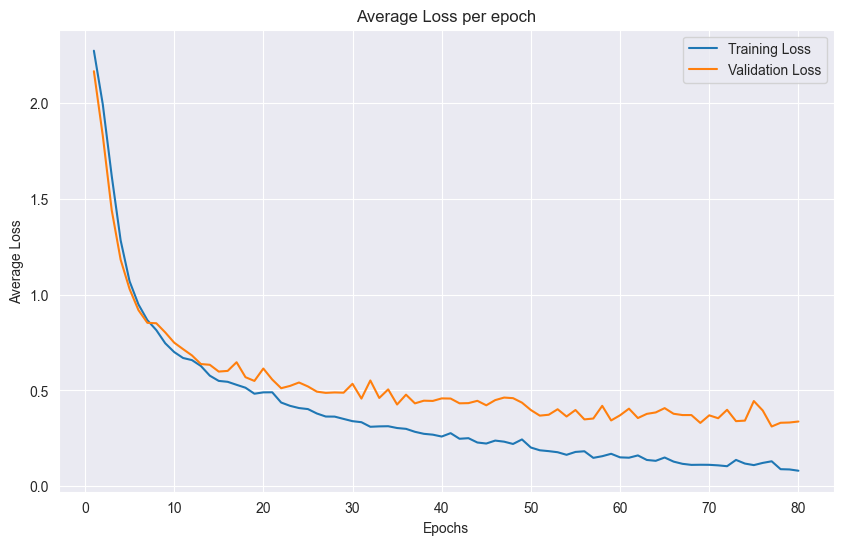

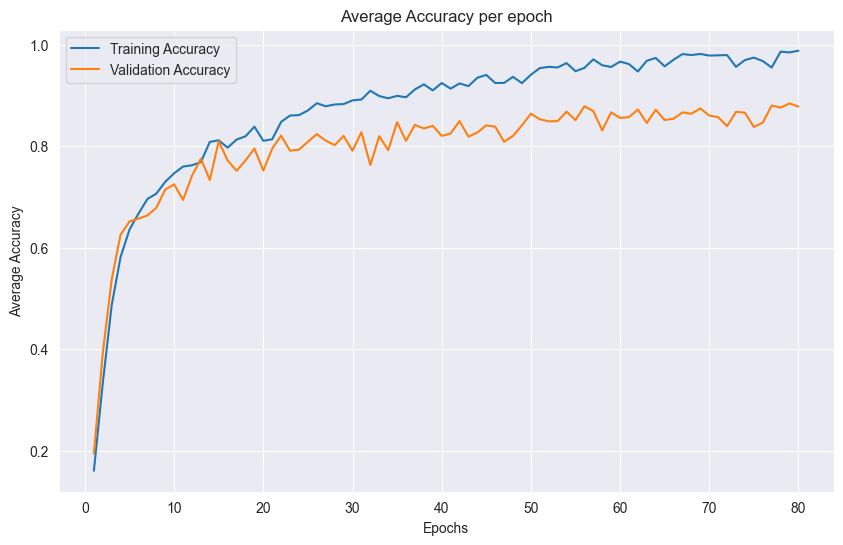

Overall Accuracy: 0.860


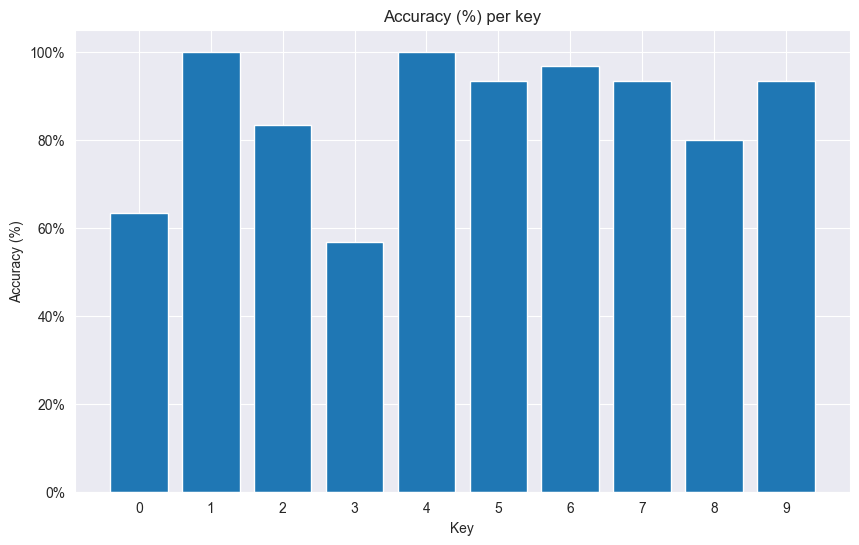

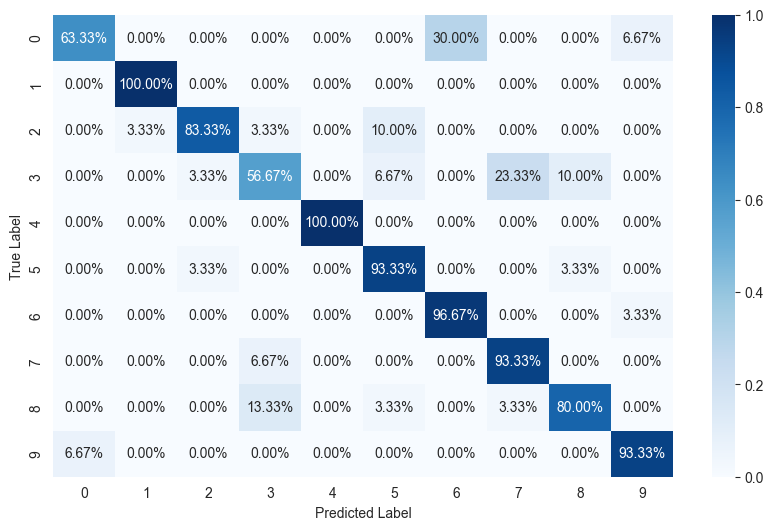

Accuracy for each key: 0: 63.333% 1: 100.0% 2: 83.333% 3: 56.667% 4: 100.0% 5: 93.333% 6: 96.667% 7: 93.333% 8: 80.0% 9: 93.333% 
              precision    recall  f1-score   support

           0       0.90      0.63      0.75        30
           1       0.97      1.00      0.98        30
           2       0.93      0.83      0.88        30
           3       0.71      0.57      0.63        30
           4       1.00      1.00      1.00        30
           5       0.82      0.93      0.88        30
           6       0.76      0.97      0.85        30
           7       0.78      0.93      0.85        30
           8       0.86      0.80      0.83        30
           9       0.90      0.93      0.92        30

    accuracy                           0.86       300
   macro avg       0.86      0.86      0.86       300
weighted avg       0.86      0.86      0.86       300

                    Model Parameters                    
Layer                    | Parameters
conv1d.weight   

In [55]:
def main():
    # setup parameters and load data
    batch_size = 64
    epochs = 80
    number_of_categories = 10
    
    X_train, X_val, X_test, y_train, y_val, y_test = importData()
    trainDataset = CSIDataset(X_train, y_train)
    valDataset = CSIDataset(X_val, y_val)
    
    trainLoader = DataLoader(trainDataset, shuffle=True, batch_size=batch_size)
    valLoader = DataLoader(valDataset, shuffle=True, batch_size=batch_size)

    model = CNN1D(number_of_categories)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    loss = nn.CrossEntropyLoss()

    # if (os.path.isfile("model.pth")):
    #     model.load_state_dict(torch.load('model.pth'))
    # else:
    #     train_loss_list, train_acc_list, eval_loss_list, eval_acc_list = train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss, (X_train.shape[0]//batch_size) + 1)
    #     # save the model
    #     torch.save(model.state_dict(), 'model.pth')
    #     plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs)
        
    train_loss_list, train_acc_list, eval_loss_list, eval_acc_list = train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss, (X_train.shape[0]//batch_size) + 1)
    plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs)
    torch.save(model.state_dict(), 'model.pth')
        
    # Simple check with test dataset
    model.eval()
    testDataset = CSIDataset(X_test, y_test)
    testLoader = DataLoader(testDataset, shuffle=True, batch_size=X_test.shape[0])
    test(model, testLoader, X_test.shape[0])
    
    print_model_parameters(model)
    
main()

(3000, 64, 40)
(3000, 2560)
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.006s...
[t-SNE] Computed neighbors for 3000 samples in 0.792s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 65.515120
[t-SNE] KL divergence after 250 iterations with early exaggeration: 4.131517
[t-SNE] KL divergence after 1000 iterations: 3.660666


[Text(0.5, 1.0, 'Amplitude data T-SNE projection')]

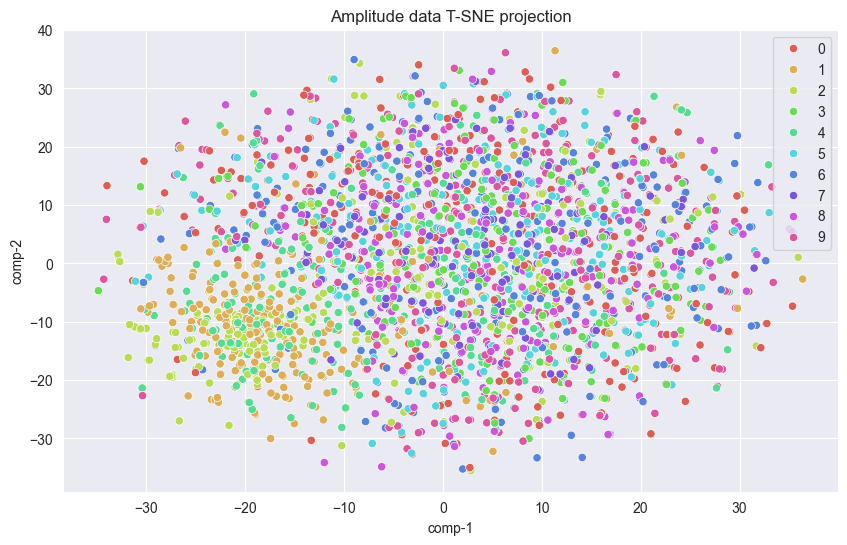

In [15]:
X_train, X_val, X_test, y_train, y_val, y_test = importData()

# stack all the samples together
X_train = np.append(X_train, X_val, axis=0)
y_train = np.append(y_train, y_val, axis=0)

X_train = np.append(X_train, X_test, axis=0)
y_train = np.append(y_train, y_test, axis=0)

X_train, y_train = shuffle(X_train, y_train)
tsne = TSNE(n_components=2, verbose=1, random_state=123, perplexity=10, learning_rate=10, early_exaggeration=1)
print(X_train.shape)
X_train = np.reshape(X_train, [X_train.shape[0], X_train.shape[1]*X_train.shape[2]])
print(X_train.shape)

z = tsne.fit_transform(X_train)

df = pd.DataFrame()
y_train = y_train.flatten()
df["y"] = y_train.tolist()
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="comp-1", y="comp-2", hue=df.y.tolist(), palette=sns.color_palette("hls", 10)).set(title="Amplitude data T-SNE projection")

In [56]:
model = CNN1D(10)
model.load_state_dict(torch.load('model.pth'))
model.eval()

k = 3
extension = ".npy"
for file in os.listdir("../data/real_env"):
    if file.endswith(extension):
        print("========" + file + "========")
        y_batch = torch.tensor([[int(i)] for i in file.split("_")[0]], dtype=torch.float32)
        X_batch = torch.tensor(np.load("../data/real_env/" + file), dtype=torch.float32)
        
        y_batch = y_batch.type(torch.LongTensor).squeeze(1)
        logits = model(X_batch)
        y_pred = F.log_softmax(logits, dim=1)
        
        predicted = np.argmax(y_pred.cpu().detach().numpy(), axis=1)
        print(f"Actual: " + f"{y_batch.tolist()}" + " Predicted: " f"{predicted}")
        values, indices = y_pred.topk(k)
        transposed_indx = torch.transpose(indices, 0, 1)
        print(f"Top k predictions: \n{transposed_indx.tolist()}")

========1436_table.npy========
Actual: [1, 4, 3, 6] Predicted: [3 3 5 5]
Top k predictions: 
[[3, 3, 5, 5], [2, 8, 2, 9], [5, 2, 3, 6]]
========1458_table.npy========
Actual: [1, 4, 5, 8] Predicted: [6 6 0 0]
Top k predictions: 
[[6, 6, 0, 0], [0, 0, 6, 6], [9, 9, 9, 9]]
========1524_table.npy========
Actual: [1, 5, 2, 4] Predicted: [1 1 1 1]
Top k predictions: 
[[1, 1, 1, 1], [4, 4, 6, 6], [8, 8, 8, 0]]
========2289_table.npy========
Actual: [2, 2, 8, 9] Predicted: [5 3 2 9]
Top k predictions: 
[[5, 3, 2, 9], [8, 5, 3, 5], [2, 8, 9, 0]]
========2379_table.npy========
Actual: [2, 3, 7, 9] Predicted: [1 1 1 2]
Top k predictions: 
[[1, 1, 1, 2], [2, 6, 2, 1], [6, 2, 4, 6]]
========3371_table.npy========
Actual: [3, 3, 7, 1] Predicted: [0 0 6 0]
Top k predictions: 
[[0, 0, 6, 0], [6, 9, 0, 9], [9, 6, 2, 6]]
========3917_table.npy========
Actual: [3, 9, 1, 7] Predicted: [1 6 1 1]
Top k predictions: 
[[1, 6, 1, 1], [2, 2, 2, 2], [8, 1, 6, 6]]
========4477_table.npy========
Actual: [4, 4, 7,